# 3-Hop Metapath Prediction Analysis

Analyzing how well 3-hop metapaths predict 1-hop metapaths.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set pandas display options to show full content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.width', None)  # Auto-detect display width

# Read the prediction metrics
df = pd.read_csv('../../metapath_prediction_metrics.tsv', sep='\t')

print(f"Loaded {len(df)} prediction pairs")
print(f"Columns: {df.columns.tolist()}")

Loaded 20000 prediction pairs
Columns: ['3hop_metapath', '1hop_metapath', '3hop_unique_pairs', '1hop_unique_pairs', 'overlap', 'total_possible_pairs', 'TP', 'FP', 'FN', 'TN', 'Total', 'Precision', 'Recall', 'Specificity', 'NPV', 'Accuracy', 'Balanced_Accuracy', 'F1', 'MCC', 'TPR', 'FPR', 'FNR', 'PLR', 'NLR']


## Optional: Filter by Start/End Node Types

You can filter to specific node type pairs (e.g., SmallMolecule → Disease) or skip this cell to analyze all predictions.

In [17]:
# Extract start and end node types from metapaths
def extract_types(metapath):
    """Extract start and end node types from a metapath string."""
    parts = metapath.split('|')
    start_type = parts[0]
    end_type = parts[-1]
    return start_type, end_type

df['start_type'] = df['3hop_metapath'].apply(lambda x: extract_types(x)[0])
df['end_type'] = df['3hop_metapath'].apply(lambda x: extract_types(x)[1])

# Show available type pairs
type_pairs = df.groupby(['start_type', 'end_type']).size().reset_index(name='count')
type_pairs_sorted = type_pairs.sort_values('count', ascending=False)

print("Available start → end type pairs:")
print(type_pairs_sorted.to_string(index=False))
print()
print(f"Total: {len(type_pairs_sorted)} unique type pairs")

Available start → end type pairs:
   start_type                 end_type  count
SmallMolecule                  Disease   3366
SmallMolecule        BiologicalProcess   2736
SmallMolecule                     Gene   2146
SmallMolecule                     Drug   1950
SmallMolecule            SmallMolecule   1722
SmallMolecule        PhenotypicFeature   1600
SmallMolecule           ChemicalEntity   1520
SmallMolecule                  Protein   1110
SmallMolecule        MolecularActivity    780
SmallMolecule         AnatomicalEntity    650
SmallMolecule        CellularComponent    585
SmallMolecule                  Pathway    560
SmallMolecule         MolecularMixture    336
SmallMolecule                     Cell    285
SmallMolecule               GeneFamily    246
SmallMolecule GrossAnatomicalStructure    215
SmallMolecule            OrganismTaxon    100
SmallMolecule                Procedure     50
SmallMolecule        ClinicalAttribute     12
SmallMolecule                 Behavior     10


In [19]:
# ====================================================================
# FILTER CONFIGURATION
# ====================================================================
# Set start_type and end_type to filter, or set to None to analyze all
# Examples:
#   - SmallMolecule → Disease: start_type='SmallMolecule', end_type='Disease'
#   - SmallMolecule → Gene: start_type='SmallMolecule', end_type='Gene'
#   - All predictions: start_type=None, end_type=None
# ====================================================================

start_type = "SmallMolecule"  # Set to specific type or None for all
end_type = "Disease"    # Set to specific type or None for all

# Save filter parameters for plot titles
filter_start = start_type
filter_end = end_type

# Apply filter if specified
df_filtered = df.copy()

if start_type is not None:
    df_filtered = df_filtered[df_filtered['start_type'] == start_type]
    print(f"Filtered to start_type: {start_type}")

if end_type is not None:
    df_filtered = df_filtered[df_filtered['end_type'] == end_type]
    print(f"Filtered to end_type: {end_type}")

if start_type is None and end_type is None:
    print("No filtering applied - analyzing all predictions")
else:
    print(f"\nFiltered from {len(df)} to {len(df_filtered)} predictions")

print()

# Create filter label for plots
if filter_start is not None and filter_end is not None:
    filter_label = f"{filter_start} → {filter_end}"
elif filter_start is not None:
    filter_label = f"{filter_start} → Any"
elif filter_end is not None:
    filter_label = f"Any → {filter_end}"
else:
    filter_label = "All Types"

# Update df to be the filtered version for all subsequent analyses
df = df_filtered

Filtered to start_type: SmallMolecule
Filtered to end_type: Disease

Filtered from 20000 to 3366 predictions



In [20]:
# Summary of filtered data
print(f"Working with {len(df)} predictions")
print(f"Unique 3-hop metapaths: {df['3hop_metapath'].nunique()}")
print(f"Unique 1-hop metapaths: {df['1hop_metapath'].nunique()}")
print()

# Show type pairs in filtered data
if len(df) > 0:
    filtered_pairs = df.groupby(['start_type', 'end_type']).size().reset_index(name='count')
    print("Type pairs in filtered dataset:")
    print(filtered_pairs.to_string(index=False))

Working with 3366 predictions
Unique 3-hop metapaths: 153
Unique 1-hop metapaths: 22

Type pairs in filtered dataset:
   start_type end_type  count
SmallMolecule  Disease   3366


## All Predictions Sorted by Precision

In [22]:
# Sort by precision (descending)
df_sorted = df.sort_values('Precision', ascending=False)

# Display with selected columns
display_cols = ['3hop_metapath', '1hop_metapath', 'Precision', 'Recall', 'F1', 'MCC', 
                '3hop_unique_pairs', '1hop_unique_pairs', 'overlap']

df_sorted[display_cols].head(20)

,3hop_metapath,1hop_metapath,Precision,Recall,F1,MCC,3hop_unique_pairs,1hop_unique_pairs,overlap
402,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.413793,0.000424,0.000846,0.013238,145,141673,60
267,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|R|Disease,SmallMolecule|ANY|A|Disease,0.338658,0.000748,0.001493,0.015918,313,141673,106
1205,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|manifestation_of|F|Disease,SmallMolecule|ANY|A|Disease,0.133333,0.000042,0.000085,0.002376,45,141673,6
1,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.056725,0.042648,0.048689,0.049182,106513,141673,6042
35,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|F|Gene|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.042019,0.006134,0.010705,0.016053,20681,141673,869
33,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|R|Gene|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.035690,0.006586,0.011119,0.015329,26142,141673,933
3,SmallMolecule|affects|F|Gene|physically_interacts_with|R|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.032955,0.028488,0.030559,0.030637,122470,141673,4036
4,SmallMolecule|affects|F|Gene|physically_interacts_with|F|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.032955,0.028488,0.030559,0.030637,122470,141673,4036
103,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|R|Gene|regulates|F|Disease,SmallMolecule|ANY|A|Disease,0.032368,0.002075,0.003900,0.008195,9083,141673,294
234,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|manifestation_of|F|Disease,SmallMolecule|positively_correlated_with|F|Disease,0.022222,0.000884,0.001701,0.004433,45,1131,1


## Filter to ANY Predictions Only

In [23]:
# Filter to rows where 1hop_metapath contains |ANY|
df_any = df[df['1hop_metapath'].str.contains(r'\|ANY\|', regex=True)].copy()

print(f"Found {len(df_any)} ANY predictions")
print()

Found 153 ANY predictions



## ANY Predictions Sorted by Precision

In [24]:
# Sort ANY predictions by precision
df_any_sorted = df_any.sort_values('Precision', ascending=False)

df_any_sorted[display_cols]

,3hop_metapath,1hop_metapath,Precision,Recall,F1,MCC,3hop_unique_pairs,1hop_unique_pairs,overlap
402,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.413793,0.000424,0.000846,0.013238,145,141673,60
267,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|R|Disease,SmallMolecule|ANY|A|Disease,0.338658,0.000748,0.001493,0.015918,313,141673,106
1205,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|manifestation_of|F|Disease,SmallMolecule|ANY|A|Disease,0.133333,0.000042,0.000085,0.002376,45,141673,6
1,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.056725,0.042648,0.048689,0.049182,106513,141673,6042
35,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|F|Gene|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.042019,0.006134,0.010705,0.016053,20681,141673,869
...,...,...,...,...,...,...,...,...,...
10503,SmallMolecule|affects|F|Gene|physically_interacts_with|F|Gene|causes|R|Disease,SmallMolecule|ANY|A|Disease,0.000000,0.000000,0.000000,-0.000001,7587,141673,0
9079,SmallMolecule|affects|F|Gene|physically_interacts_with|R|Gene|disrupts|R|Disease,SmallMolecule|ANY|A|Disease,0.000000,0.000000,0.000000,-0.000001,2292,141673,0
8858,SmallMolecule|affects|F|Gene|physically_interacts_with|R|Gene|affects|F|Disease,SmallMolecule|ANY|A|Disease,0.000000,0.000000,0.000000,-0.000003,79755,141673,0
8607,SmallMolecule|affects|F|Gene|physically_interacts_with|R|Gene|causes|R|Disease,SmallMolecule|ANY|A|Disease,0.000000,0.000000,0.000000,-0.000001,7587,141673,0


## Precision vs Recall - All Predictions

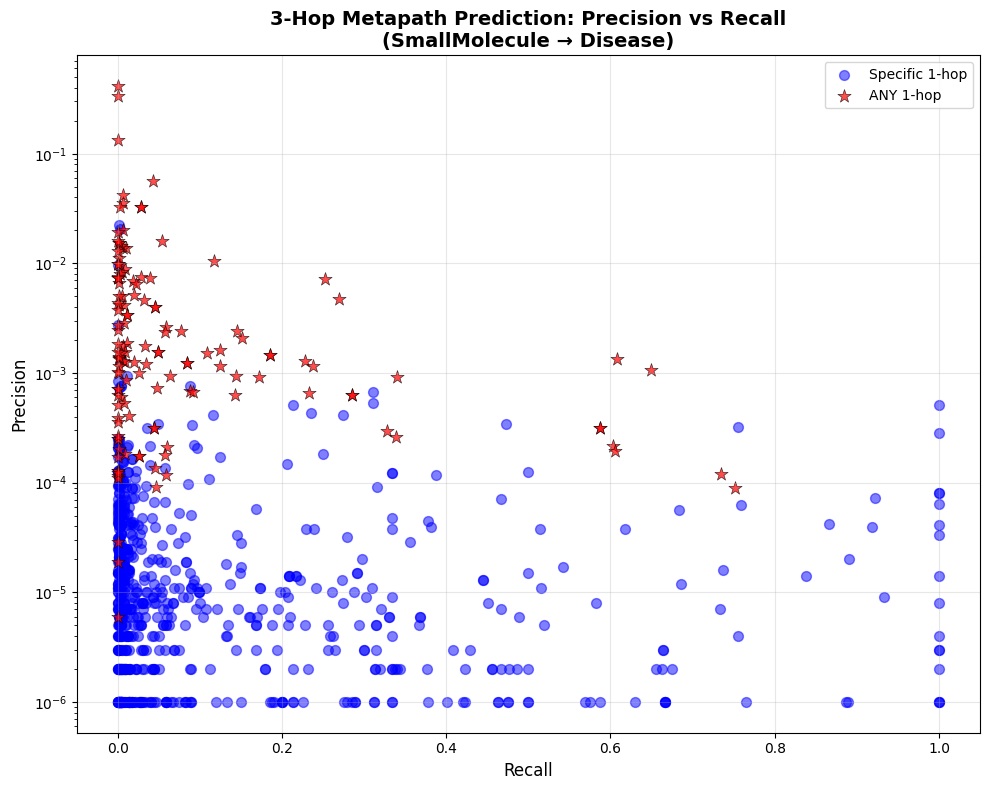

Saved plot to 3hop_prediction_precision_recall.png


In [25]:
# Create precision-recall scatter plot for all predictions
fig, ax = plt.subplots(figsize=(10, 8))

# Separate ANY and specific predictions
df_specific = df[~df['1hop_metapath'].str.contains(r'\|ANY\|', regex=True)]

# Plot specific predictions in blue
ax.scatter(df_specific['Recall'], df_specific['Precision'], 
           alpha=0.5, s=50, c='blue', label='Specific 1-hop')

# Plot ANY predictions in red with larger markers
ax.scatter(df_any['Recall'], df_any['Precision'], 
           alpha=0.7, s=100, c='red', marker='*', label='ANY 1-hop', edgecolors='black', linewidths=0.5)

# Labels and formatting
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'3-Hop Metapath Prediction: Precision vs Recall\n({filter_label})', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Use log scale for precision since values are very small
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../3hop_prediction_precision_recall.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved plot to 3hop_prediction_precision_recall.png")

## Precision vs Recall - Linear Scale (Zoomed)

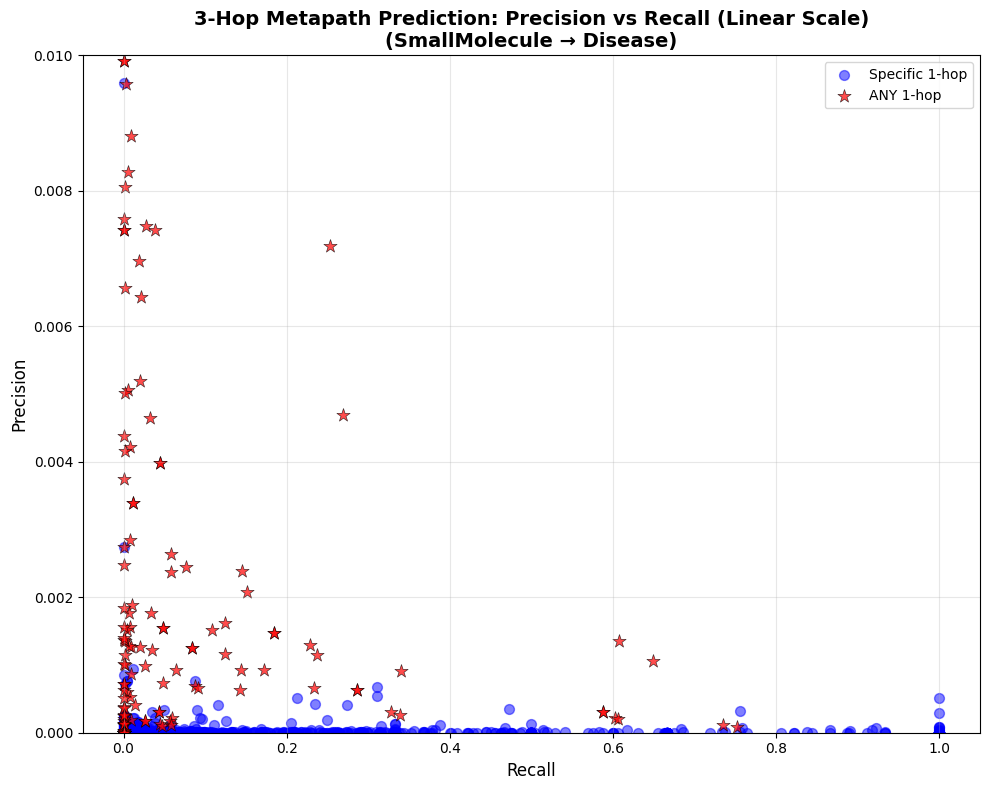

Saved plot to 3hop_prediction_precision_recall_linear.png


In [26]:
# Create linear scale version with zoom on the high-precision region
fig, ax = plt.subplots(figsize=(10, 8))

# Plot specific predictions in blue
ax.scatter(df_specific['Recall'], df_specific['Precision'], 
           alpha=0.5, s=50, c='blue', label='Specific 1-hop')

# Plot ANY predictions in red with larger markers
ax.scatter(df_any['Recall'], df_any['Precision'], 
           alpha=0.7, s=100, c='red', marker='*', label='ANY 1-hop', edgecolors='black', linewidths=0.5)

# Labels and formatting
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'3-Hop Metapath Prediction: Precision vs Recall (Linear Scale)\n({filter_label})', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Set y-axis limit to show more detail (zoom to top 1%)
max_precision = df['Precision'].max()
ax.set_ylim(0, min(0.01, max_precision * 1.1))

plt.tight_layout()
plt.savefig('../../3hop_prediction_precision_recall_linear.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved plot to 3hop_prediction_precision_recall_linear.png")

## Summary Statistics

In [27]:
print("=" * 80)
print("SUMMARY STATISTICS - ALL PREDICTIONS")
print("=" * 80)
print()
print(df[['Precision', 'Recall', 'F1', 'MCC', 'Accuracy']].describe())
print()

print("=" * 80)
print("SUMMARY STATISTICS - ANY PREDICTIONS ONLY")
print("=" * 80)
print()
print(df_any[['Precision', 'Recall', 'F1', 'MCC', 'Accuracy']].describe())
print()

print("=" * 80)
print("SUMMARY STATISTICS - SPECIFIC PREDICTIONS ONLY")
print("=" * 80)
print()
print(df_specific[['Precision', 'Recall', 'F1', 'MCC', 'Accuracy']].describe())

SUMMARY STATISTICS - ALL PREDICTIONS

         Precision       Recall           F1          MCC     Accuracy
count  3366.000000  3366.000000  3366.000000  3366.000000  3366.000000
mean      0.000487     0.071365     0.000169     0.000575     0.999063
std       0.009714     0.192445     0.001486     0.002593     0.003828
min       0.000000     0.000000     0.000000    -0.000029     0.965268
25%       0.000000     0.000000     0.000000     0.000000     0.999720
50%       0.000000     0.000000     0.000000    -0.000000     0.999988
75%       0.000001     0.012500     0.000001     0.000138     0.999999
max       0.413793     1.000000     0.048689     0.049182     1.000000

SUMMARY STATISTICS - ANY PREDICTIONS ONLY

        Precision      Recall          F1         MCC    Accuracy
count  153.000000  153.000000  153.000000  153.000000  153.000000
mean     0.010164    0.074619    0.003333    0.007376    0.999060
std      0.044534    0.153877    0.006166    0.008761    0.003839
min      0.0000

## Pareto Optimal Predictions

Finding predictions where no other prediction has both higher precision AND higher recall.

In [28]:
def find_pareto_optimal(df, precision_col='Precision', recall_col='Recall'):
    """
    Find Pareto optimal points where no other point has both higher precision AND higher recall.
    
    A point is Pareto optimal if there's no other point that dominates it
    (i.e., has both >= precision and >= recall, with at least one strictly greater).
    """
    pareto_mask = np.ones(len(df), dtype=bool)
    
    for i in range(len(df)):
        if not pareto_mask[i]:
            continue
        
        precision_i = df.iloc[i][precision_col]
        recall_i = df.iloc[i][recall_col]
        
        # Check if any other point dominates this one
        for j in range(len(df)):
            if i == j:
                continue
            
            precision_j = df.iloc[j][precision_col]
            recall_j = df.iloc[j][recall_col]
            
            # Point j dominates point i if both metrics are >= and at least one is strictly >
            if (precision_j >= precision_i and recall_j >= recall_i and 
                (precision_j > precision_i or recall_j > recall_i)):
                pareto_mask[i] = False
                break
    
    return df[pareto_mask].copy()

### Pareto Optimal - All Predictions

In [29]:
# Find Pareto optimal predictions across all predictions
pareto_all = find_pareto_optimal(df)

print(f"Found {len(pareto_all)} Pareto optimal predictions out of {len(df)} total")
print()

# Sort by F1 score
pareto_all_sorted = pareto_all.sort_values('F1', ascending=False)

# Display
pareto_all_sorted[display_cols]

Found 10 Pareto optimal predictions out of 3366 total



,3hop_metapath,1hop_metapath,Precision,Recall,F1,MCC,3hop_unique_pairs,1hop_unique_pairs,overlap
1,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.056725,0.042648,0.048689,0.049182,106513,141673,6042
6,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|affects|F|Disease,SmallMolecule|ANY|A|Disease,0.016125,0.054202,0.024856,0.029557,476208,141673,7679
12,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.010617,0.116515,0.019460,0.035158,1554826,141673,16507
21,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|F|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.007188,0.252490,0.013978,0.042580,4976427,141673,35771
42,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|R|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.004685,0.268802,0.009210,0.035461,8128243,141673,38082
155,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|F|Disease,SmallMolecule|ANY|A|Disease,0.001355,0.608020,0.002704,0.028642,63572601,141673,86140
194,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.001065,0.649658,0.002127,0.026237,86405609,141673,92039
267,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|R|Disease,SmallMolecule|ANY|A|Disease,0.338658,0.000748,0.001493,0.015918,313,141673,106
357,SmallMolecule|affects|F|Gene|affects|R|SmallMolecule|diagnoses|F|Disease,SmallMolecule|diagnoses|F|Disease,0.000510,1.000000,0.001020,0.022588,1960,1,1
402,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.413793,0.000424,0.000846,0.013238,145,141673,60


### Pareto Optimal - ANY Predictions Only

In [30]:
# Find Pareto optimal predictions among ANY predictions only
pareto_any = find_pareto_optimal(df_any)

print(f"Found {len(pareto_any)} Pareto optimal ANY predictions out of {len(df_any)} total ANY predictions")
print()

# Sort by F1 score
pareto_any_sorted = pareto_any.sort_values('F1', ascending=False)

# Display
pareto_any_sorted[display_cols]

Found 11 Pareto optimal ANY predictions out of 153 total ANY predictions



,3hop_metapath,1hop_metapath,Precision,Recall,F1,MCC,3hop_unique_pairs,1hop_unique_pairs,overlap
1,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|R|Disease,SmallMolecule|ANY|A|Disease,0.056725,0.042648,0.048689,0.049182,106513,141673,6042
6,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|affects|F|Disease,SmallMolecule|ANY|A|Disease,0.016125,0.054202,0.024856,0.029557,476208,141673,7679
12,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.010617,0.116515,0.019460,0.035158,1554826,141673,16507
21,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|F|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.007188,0.252490,0.013978,0.042580,4976427,141673,35771
42,SmallMolecule|affects|F|Gene|directly_physically_interacts_with|R|Gene|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.004685,0.268802,0.009210,0.035461,8128243,141673,38082
155,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|F|Disease,SmallMolecule|ANY|A|Disease,0.001355,0.608020,0.002704,0.028642,63572601,141673,86140
194,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|treats_or_applied_or_studied_to_treat|F|Disease,SmallMolecule|ANY|A|Disease,0.001065,0.649658,0.002127,0.026237,86405609,141673,92039
267,SmallMolecule|affects|F|Gene|affects|F|SmallMolecule|contributes_to|R|Disease,SmallMolecule|ANY|A|Disease,0.338658,0.000748,0.001493,0.015918,313,141673,106
402,SmallMolecule|affects|F|Gene|expressed_in|F|Cell|positively_correlated_with|F|Disease,SmallMolecule|ANY|A|Disease,0.413793,0.000424,0.000846,0.013238,145,141673,60
760,SmallMolecule|affects|F|Gene|affects|R|SmallMolecule|contributes_to|F|Disease,SmallMolecule|ANY|A|Disease,0.000119,0.734720,0.000238,0.009152,872827957,141673,104090


### Pareto Frontier Visualization

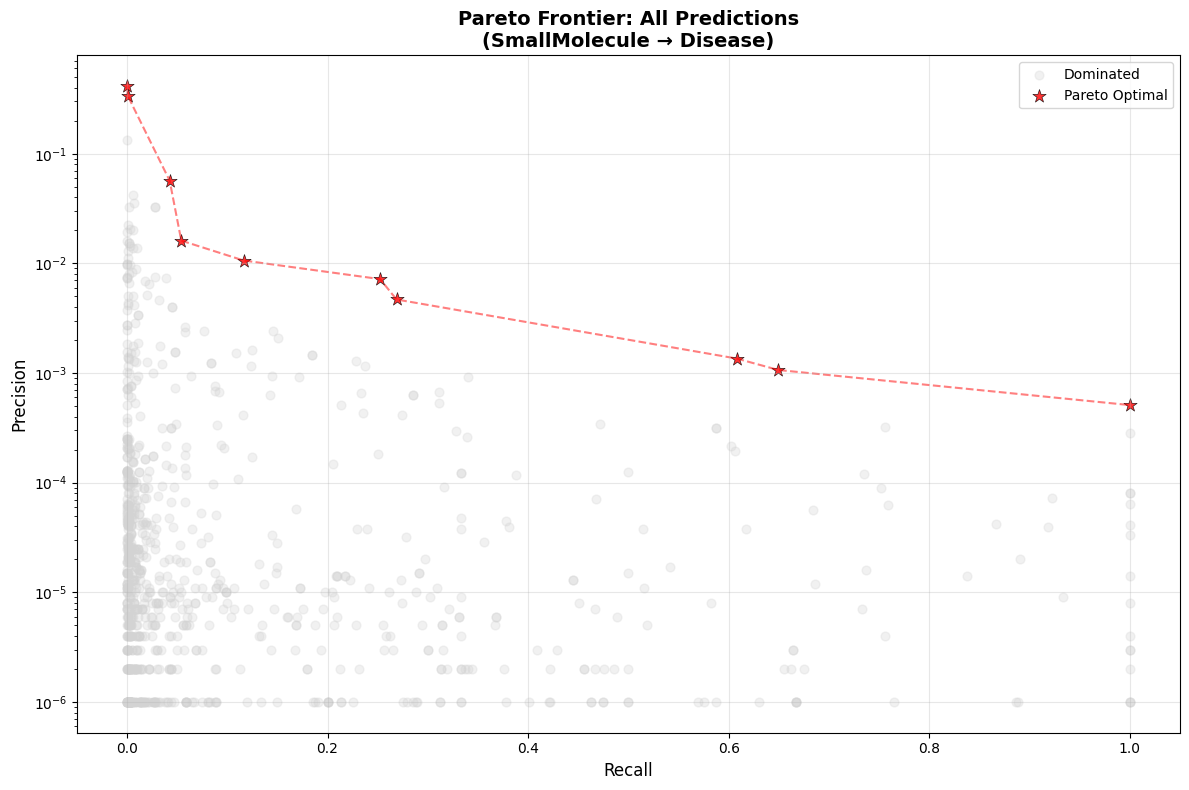

Saved plot to 3hop_pareto_frontier_all.png


In [31]:
# Plot Pareto frontier for all predictions
fig, ax = plt.subplots(figsize=(12, 8))

# Get dominated points (not Pareto optimal)
dominated = df[~df.index.isin(pareto_all.index)]

# Plot dominated points in light gray
ax.scatter(dominated['Recall'], dominated['Precision'], 
           alpha=0.3, s=40, c='lightgray', label='Dominated')

# Plot Pareto optimal points in red
ax.scatter(pareto_all['Recall'], pareto_all['Precision'], 
           alpha=0.8, s=100, c='red', marker='*', 
           label='Pareto Optimal', edgecolors='black', linewidths=0.5)

# Sort Pareto points by recall and draw the frontier line
pareto_sorted = pareto_all.sort_values('Recall')
ax.plot(pareto_sorted['Recall'], pareto_sorted['Precision'], 
        'r--', alpha=0.5, linewidth=1.5, zorder=1)

# Labels and formatting
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'Pareto Frontier: All Predictions\n({filter_label})', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../3hop_pareto_frontier_all.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to 3hop_pareto_frontier_all.png")

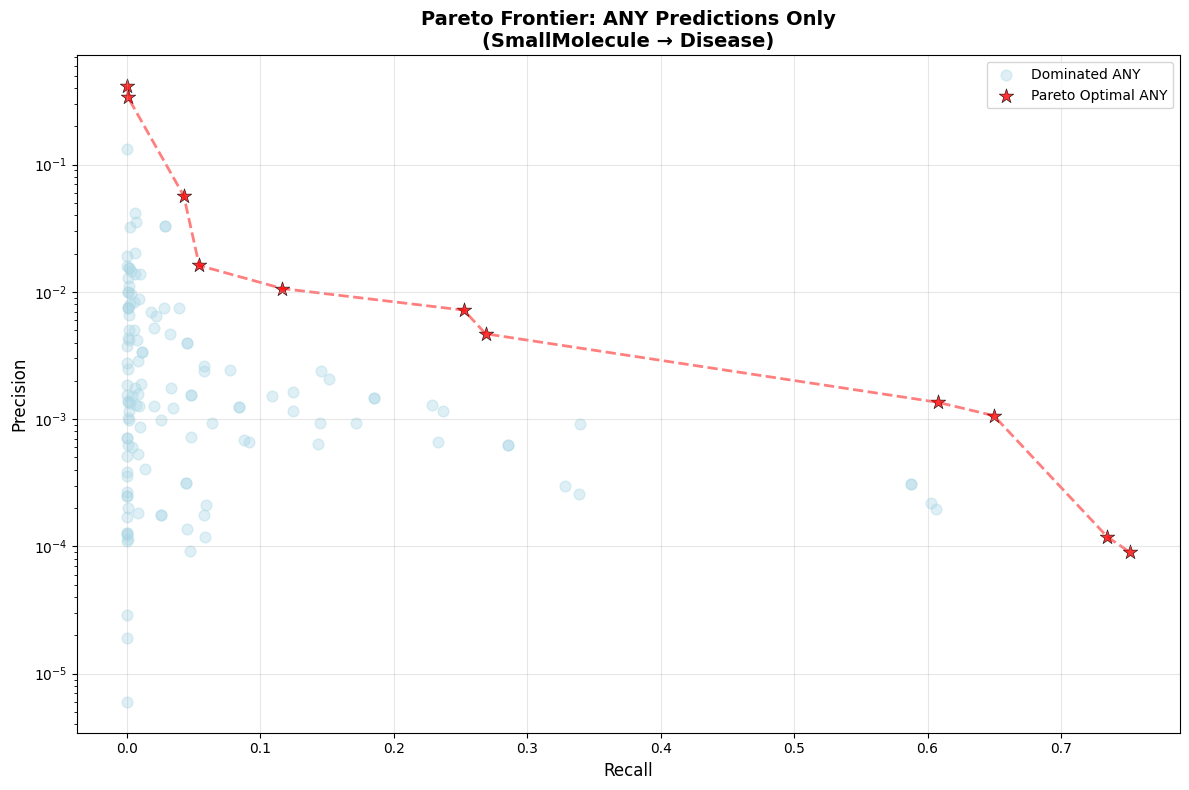

Saved plot to 3hop_pareto_frontier_any.png


In [32]:
# Plot Pareto frontier for ANY predictions only
fig, ax = plt.subplots(figsize=(12, 8))

# Get dominated ANY points
dominated_any = df_any[~df_any.index.isin(pareto_any.index)]

# Plot dominated points in light blue
ax.scatter(dominated_any['Recall'], dominated_any['Precision'], 
           alpha=0.4, s=60, c='lightblue', label='Dominated ANY')

# Plot Pareto optimal ANY points in red
ax.scatter(pareto_any['Recall'], pareto_any['Precision'], 
           alpha=0.8, s=120, c='red', marker='*', 
           label='Pareto Optimal ANY', edgecolors='black', linewidths=0.5)

# Sort Pareto points by recall and draw the frontier line
pareto_any_sorted_plot = pareto_any.sort_values('Recall')
ax.plot(pareto_any_sorted_plot['Recall'], pareto_any_sorted_plot['Precision'], 
        'r--', alpha=0.5, linewidth=2, zorder=1)

# Labels and formatting
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'Pareto Frontier: ANY Predictions Only\n({filter_label})', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../3hop_pareto_frontier_any.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to 3hop_pareto_frontier_any.png")

### Save Pareto Optimal Results

In [33]:
# Save Pareto optimal results to TSV files

# All Pareto optimal predictions
pareto_all_file = '../../3hop_pareto_optimal_all.tsv'
pareto_all_sorted.to_csv(pareto_all_file, sep='\t', index=False, float_format='%.6f')
print(f"Saved {len(pareto_all_sorted)} Pareto optimal predictions (all) to {pareto_all_file}")

# ANY Pareto optimal predictions
pareto_any_file = '../../3hop_pareto_optimal_any.tsv'
pareto_any_sorted.to_csv(pareto_any_file, sep='\t', index=False, float_format='%.6f')
print(f"Saved {len(pareto_any_sorted)} Pareto optimal predictions (ANY) to {pareto_any_file}")

Saved 10 Pareto optimal predictions (all) to ../../3hop_pareto_optimal_all.tsv
Saved 11 Pareto optimal predictions (ANY) to ../../3hop_pareto_optimal_any.tsv
